In [144]:
import numpy as np
import matplotlib.pyplot as plt
import lib

### Parse and sort into training and testing data set
Structure:
I datasett-arrayet er hver rad ett enkelt sample. Første kolonne sier klassetilhørlighet, og de andre kolonnene sier egenskapsverdiene for dette sampelet
$$
\begin{bmatrix}
\Omega(\vec{x}_1) & \vec{x}_{1,1} & \vec{x}_{1,2} & \vec{x}_{1,3} & \vec{x}_{1,4}\\
\Omega(\vec{x}_2) & \vec{x}_{2,1} & \vec{x}_{2,2} & \vec{x}_{2,3} & \vec{x}_{2,4}\\
. & . & . & . & . \\
. & . & . & . & . \\
\Omega(\vec{x}_n) & \vec{x}_{n,1} & \vec{x}_{n,2} & \vec{x}_{n,3} & \vec{x}_{n,4}\\
\end{bmatrix}	
$$
hvor $\Omega(\vec{x}_k) \in \left\{ \omega_1, \omega_2 \right\}$ er klassetilhørigheten til sampelet $\vec{x}_k$, og
$\vec{x}_{k,i}$ er sampelet $\vec{x}_{k}$ sin verdi for egenskap $i$

Datasett 1: 5 kolonner (4 egenskaper), 300 rader (300 sampler)

Datasett 2: 4 kolonner (3 egenskaper), 300 rader (300 sampler)

Datasett 3: 4 kolonner (3 egenskaper), 400 rader (400 sampler)

In [145]:
data = lib.DataSet('data/ds-1.txt')

## Plott egenskap 1 for alle objekter av klasse 1 og klasse 2
Vi kan se at distribusjonen ligner på en normalfordeling. Den samme egenskapen ser ut til å ha forskjellig forventningsverdi $\mu$, og muligens forskjellig varians $\sigma$

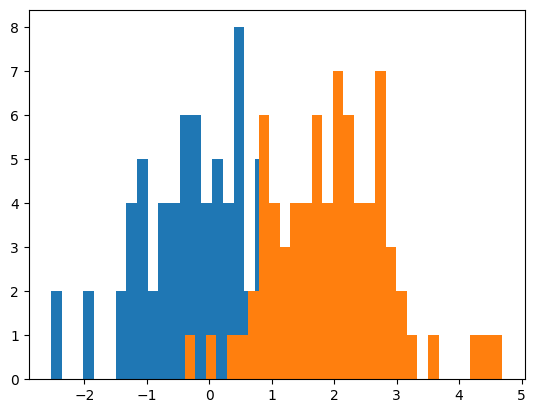

In [146]:
feature = 1
class_1_dataset = data.training[data.training[:,0] == 1]
class_2_dataset = data.testing[data.testing[:,0] == 2]
class_1_feature = class_1_dataset[:,feature]
class_2_feature = class_2_dataset[:,feature]

plt.hist(class_1_feature, 30)
plt.hist(class_2_feature, 30)
plt.show()

# Minimum Feilrate Klassifikator
Her settes opp funksjoner for å beregne størrelsene som er nødvendig for å sette opp diskriminantfunksjonen som skal brukes for å bestemme klassene i nye sampler.

Til slutt kombineres disse i en "pipeline" som tar inn et gitt datasett, trener opp klassifikatoren og bruker den på test-settet.

In [147]:
def get_a_priori_probability(dataset, class_number):
    num_samples = dataset.shape[0]
    class_samples = dataset[dataset[:, 0] == class_number]
    class_sample_count = class_samples.shape[0]
    return class_sample_count/num_samples

def get_sample_mean(dataset, class_number):
    class_samples = dataset[dataset[:,0] == class_number] # extract data only for the given class
    class_samples = class_samples[:, 1:] # remove the first column (the assigned class)
    mu = np.mean(class_samples, axis = 0) # get the mean of the samples
    return mu

def get_sample_variance(dataset, class_number, mu):
    class_samples = dataset[dataset[:, 0] == class_number, 1:]
    mean_centered_samples = class_samples - mu
    n_samples = class_samples.shape[0]
    variance = np.dot(mean_centered_samples.T, mean_centered_samples) / n_samples
    return variance

def get_W_matrix(sigma):
    return -(1/2)*np.linalg.inv(sigma)

def get_w_vector(sigma, mu):
    return np.linalg.inv(sigma)@mu

def get_w0(sigma, mu, P_class):
    return -(1/2)*mu.T@np.linalg.inv(sigma)@mu - (1/2)*np.log(np.linalg.det(sigma)) + np.log(P_class)

def g_i(sample, W_i, w_i, w_i_0):
    return sample.T@W_i@sample + w_i.T@sample + w_i_0

def discriminant_function(sample, W_1, W_2, w_1, w_2, w_1_0, w_2_0):
    sample = sample[1:] # ignore class column
    g_1 = g_i(sample, W_1, w_1, w_1_0)
    g_2 = g_i(sample, W_2, w_2, w_2_0)
    return g_1-g_2

def minimum_error_pipeline(data):
    P_class_1 = get_a_priori_probability(data.training, 1)
    P_class_2 = get_a_priori_probability(data.training, 2)
    mu_1 = get_sample_mean(data.training, 1)
    mu_2 = get_sample_mean(data.training, 2)
    sigma_1 = get_sample_variance(data.training, 1, mu_1)
    sigma_2 = get_sample_variance(data.training, 2, mu_1)

    W_1 = get_W_matrix(sigma_1)
    W_2 = get_W_matrix(sigma_2)
    w_1 = get_w_vector(sigma_1, mu_1)
    w_2 = get_w_vector(sigma_2, mu_2)
    w_1_0 = get_w0(sigma_1, mu_1, P_class_1)
    w_2_0 = get_w0(sigma_2, mu_2, P_class_2)

    n_correct = 0
    n_incorrect = 0
    for sample in data.testing:
        true_class = sample[0]
        score = discriminant_function(sample, W_1, W_2, w_1, w_2, w_1_0, w_2_0)
        if score > 0:
            assigned_class = 1
        else:
            assigned_class = 2
        if (true_class == assigned_class):
            n_correct += 1
        else:
            n_incorrect += 1
    
    print('---------')
    print(f"{data.path}")
    print(f"accuracy: {n_correct/(n_correct+n_incorrect)*100}%")

## Minste kvadraters

In [148]:
def lq_discriminant(sample, a):
    x = sample[1:]
    y = np.insert(x, 0, 1)
    return a.T@y

def lq_pipeline(data):
    Y = np.copy(data.training)
    Y[:,0] = 1 
    b = data.training[:, 0]
    b = np.where(b == 2, -1, 1)
    a = np.linalg.inv(Y.T@Y)@Y.T@b

    n_correct = 0
    n_incorrect = 0
    for sample in data.training:
        true_class = sample[0]
        result = lq_discriminant(sample, a)
        if result >= 0:
            assigned_class = 1
        else:
            assigned_class = 2
        if assigned_class == true_class:
            n_correct += 1
        else:
            n_incorrect += 1

    print('---------')
    print(f"{data.path}")
    print(f"accuracy: {n_correct/(n_correct+n_incorrect)*100}%")

In [149]:
data_1 = lib.DataSet('data/ds-1.txt')
data_2 = lib.DataSet('data/ds-2.txt')
data_3 = lib.DataSet('data/ds-3.txt')
print("--- MINIMUM ERROR CLASSIFIER ---")
minimum_error_pipeline(data_1)
minimum_error_pipeline(data_2)
minimum_error_pipeline(data_3)
print("\n \n --- LEAST SQUARES CLASSIFIER ---")
lq_pipeline(data_1)
lq_pipeline(data_2)
lq_pipeline(data_3)

--- MINIMUM ERROR CLASSIFIER ---
---------
data/ds-1.txt
accuracy: 90.66666666666666%
---------
data/ds-2.txt
accuracy: 94.0%
---------
data/ds-3.txt
accuracy: 89.5%

 
 --- LEAST SQUARES CLASSIFIER ---
---------
data/ds-1.txt
accuracy: 90.66666666666666%
---------
data/ds-2.txt
accuracy: 86.66666666666667%
---------
data/ds-3.txt
accuracy: 90.5%
